In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
import urllib
import zipfile
import os
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score, classification_report

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
url = "http://nlp.stanford.edu/data/glove.6B.zip"
extract_dir = os.path.join(os.path.curdir, "glove")

if not os.path.exists(os.path.join(os.path.curdir, "glove", "glove.6B.300d.txt")):
    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(extract_dir)

In [3]:
embed_size = 300 # how big is each word vector
max_features = 120000
batch_size = 128 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
data1 = pd.read_csv(os.path.join(os.path.curdir, "data", "train_all_tasks.csv")).fillna(' ')

In [5]:
df = data1[data1.label_sexist == 'sexist']

In [6]:
ndf = data1[data1.label_sexist == 'not sexist']

In [7]:
add_df = ndf.sample(2000)

In [8]:
frames = [add_df,df]
data = pd.concat(frames)

In [9]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_sexist'],
                                                    stratify=data['label_sexist'], 
                                                    test_size=0.25)

In [10]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (4048,)
Test shape :  (1350,)


In [11]:
START_TOKEN = "<STR>"
STOP_TOKEN = "<STP>"
UNK_TOKEN = "<UNK>"
NULL_TOKEN = "<NUL>"

def clean_text(text):
    text = re.sub('[URL]', '', text) # remove [URL]
    text = re.sub('[USER]', '', text) # remove [USER]
    text = re.sub(r'<.*?>', '', text)  # remove html tags
    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'www\S+', '', text)  # remove www website
    text = re.sub(r'[^\w\s]', '', text) # remove special characters like !,@,#,$,%
    text = re.sub('\s+', ' ', text) # replace multiple space by single space
    text = START_TOKEN + " " + text.strip() + " " + STOP_TOKEN # add START and STOP tokens
    return text

def create_vocab(data):
    texts_split = [text for text in data]
    all_text =' '.join([texts for texts in texts_split])
    words = all_text.split()
    counts = Counter(words)
    counts[START_TOKEN] = len(counts)
    counts[STOP_TOKEN] = len(counts)
    counts[UNK_TOKEN] = len(counts)
    counts[NULL_TOKEN] = len(counts)
    vocab = sorted(counts, key=counts.get, reverse=True)
    vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    return vocab_to_int

def text2idx(text, vocab_to_int):
    text = text.split() 
    idx = [vocab_to_int[UNK_TOKEN] for i in range(len(text))]
    for i in range(len(text)):
        w = text[i]
        if w in vocab_to_int:
            idx[i] = vocab_to_int[w]
        else:
            idx[i] = vocab_to_int[UNK_TOKEN]
    return idx

def pad_text(encoded_text, pad_token, max_len = 300):
    pad_count = max_len - len(encoded_text)
    return [pad_token for i in range(pad_count)] + encoded_text

def get_max_len(data):
    mx_len = 0
    for rw in data:
        mx_len = max(mx_len, len(rw.split()))
    return mx_len

cleaned_train_X = [clean_text(text) for text in train_X]
mx_len = get_max_len(cleaned_train_X) + 5 # add 5 to max_len for buffer
vocab_to_int = create_vocab(cleaned_train_X)
train_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_train_X], dtype = np.int32)

cleaned_test_X = [clean_text(text) for text in test_X]
test_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_test_X], dtype = np.int32)

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [13]:
def load_glove(word_index):
    EMBEDDING_FILE = os.path.join(os.path.curdir, "glove", "glove.6B.300d.txt")
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf-8"))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [14]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(vocab_to_int)

E:\Softwares\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [17]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_12328\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=84.2478 	 val_loss=80.8124  	 val_acc=0.6296  	 time=5.27s
Epoch 2/40 	 loss=83.0444 	 val_loss=80.2240  	 val_acc=0.6296  	 time=0.34s
Epoch 3/40 	 loss=82.4882 	 val_loss=79.6468  	 val_acc=0.6296  	 time=0.33s
Epoch 4/40 	 loss=81.9471 	 val_loss=79.0225  	 val_acc=0.6296  	 time=0.33s
Epoch 5/40 	 loss=81.4523 	 val_loss=78.2180  	 val_acc=0.6296  	 time=0.34s
Epoch 6/40 	 loss=80.5330 	 val_loss=77.2326  	 val_acc=0.6311  	 time=0.33s
Epoch 7/40 	 loss=79.3593 	 val_loss=75.9974  	 val_acc=0.6430  	 time=0.32s
Epoch 8/40 	 loss=77.9283 	 val_loss=74.4742  	 val_acc=0.6607  	 time=0.33s
Epoch 9/40 	 loss=76.2069 	 val_loss=72.6001  	 val_acc=0.6830  	 time=0.33s
Epoch 10/40 	 loss=74.0836 	 val_loss=70.5465  	 val_acc=0.7141  	 time=0.34s
Epoch 11/40 	 loss=71.8593 	 val_loss=68.4235  	 val_acc=0.7281  	 time=0.34s
Epoch 12/40 	 loss=69.7069 	 val_loss=66.5415  	 val_acc=0.7467  	 time=0.35s
Epoch 13/40 	 loss=67.4860 	 val_loss=64.4952  	 val_acc=0.7519  	 time=0

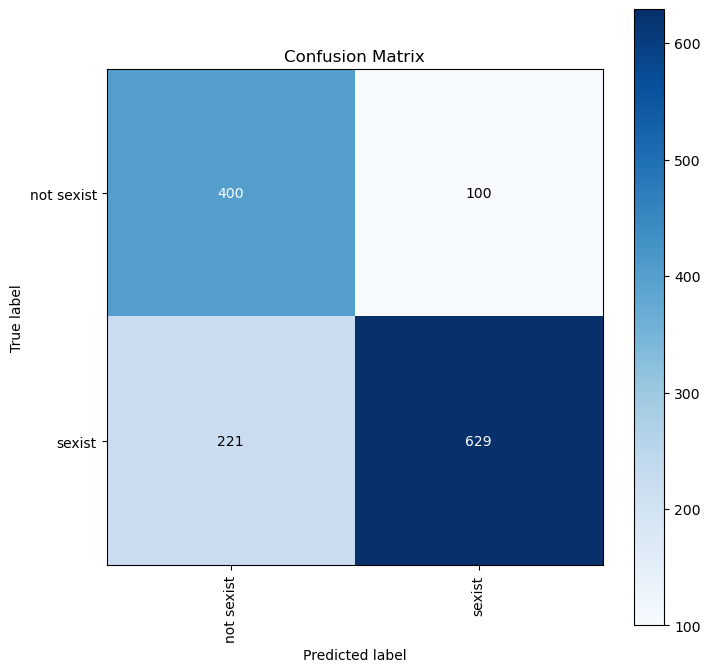

In [18]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_a_confusion_matrix"))

In [19]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_a_classification_report"), index= True)

              precision    recall  f1-score   support

  not sexist       0.64      0.80      0.71       500
      sexist       0.86      0.74      0.80       850

    accuracy                           0.76      1350
   macro avg       0.75      0.77      0.76      1350
weighted avg       0.78      0.76      0.77      1350



# **TASK B**

In [20]:
df = data1[data1.label_sexist == 'sexist']

In [21]:
ndf = data1[data1.label_sexist == 'not sexist']

In [22]:
add_df = ndf.sample(800)

In [23]:
frames = [add_df,df]
data = pd.concat(frames)

In [24]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_category'],
                                                    stratify=data['label_category'], 
                                                    test_size=0.25)

In [25]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3148,)
Test shape :  (1050,)


In [26]:
cleaned_train_X = [clean_text(text) for text in train_X]
mx_len = get_max_len(cleaned_train_X) + 5 # add 5 to max_len for buffer
vocab_to_int = create_vocab(cleaned_train_X)
train_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_train_X], dtype = np.int32)

cleaned_test_X = [clean_text(text) for text in test_X]
test_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_test_X], dtype = np.int32)

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [28]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_12328\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=204.1596 	 val_loss=185.8517  	 val_acc=0.2762  	 time=0.56s
Epoch 2/40 	 loss=196.5841 	 val_loss=177.9497  	 val_acc=0.3648  	 time=0.26s
Epoch 3/40 	 loss=187.9770 	 val_loss=170.8004  	 val_acc=0.3790  	 time=0.27s
Epoch 4/40 	 loss=182.1832 	 val_loss=168.0476  	 val_acc=0.3790  	 time=0.26s
Epoch 5/40 	 loss=180.7530 	 val_loss=167.5142  	 val_acc=0.3790  	 time=0.26s
Epoch 6/40 	 loss=180.6411 	 val_loss=167.3329  	 val_acc=0.3790  	 time=0.26s
Epoch 7/40 	 loss=180.3246 	 val_loss=167.2002  	 val_acc=0.3790  	 time=0.28s
Epoch 8/40 	 loss=180.5352 	 val_loss=167.0793  	 val_acc=0.3790  	 time=0.27s
Epoch 9/40 	 loss=179.9985 	 val_loss=166.9422  	 val_acc=0.3790  	 time=0.28s
Epoch 10/40 	 loss=180.0344 	 val_loss=166.8324  	 val_acc=0.3790  	 time=0.28s
Epoch 11/40 	 loss=179.6628 	 val_loss=166.7074  	 val_acc=0.3790  	 time=0.27s
Epoch 12/40 	 loss=179.2359 	 val_loss=166.5824  	 val_acc=0.3790  	 time=0.26s
Epoch 13/40 	 loss=179.3558 	 val_loss=166.4846  

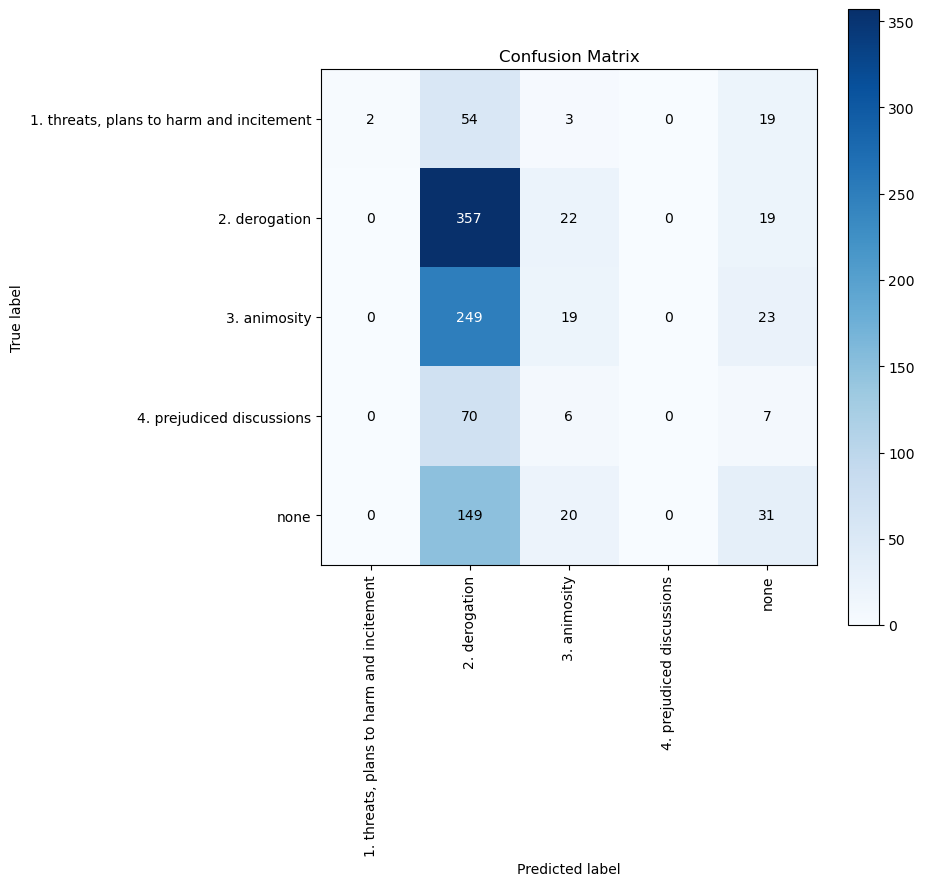

In [29]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_b_confusion_matrix"))

In [30]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_b_classification_report"), index= True)

                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       1.00      0.03      0.05        78
                           2. derogation       0.41      0.90      0.56       398
                            3. animosity       0.27      0.07      0.11       291
               4. prejudiced discussions       0.00      0.00      0.00        83
                                    none       0.31      0.15      0.21       200

                                accuracy                           0.39      1050
                               macro avg       0.40      0.23      0.18      1050
                            weighted avg       0.36      0.39      0.28      1050



E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla

# **TASK C**

In [31]:
df = data1[data1.label_sexist == 'sexist']

In [32]:
ndf = data1[data1.label_sexist == 'not sexist']

In [33]:
add_df = ndf.sample(800)

In [34]:
frames = [add_df,df]
data = pd.concat(frames)

In [35]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['text'], data['label_vector'],
                                                    stratify=data['label_vector'], 
                                                    test_size=0.25)

In [36]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3148,)
Test shape :  (1050,)


In [37]:
cleaned_train_X = [clean_text(text) for text in train_X]
mx_len = get_max_len(cleaned_train_X) + 5 # add 5 to max_len for buffer
vocab_to_int = create_vocab(cleaned_train_X)
train_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_train_X], dtype = np.int32)

cleaned_test_X = [clean_text(text) for text in test_X]
test_X = np.array([pad_text(text2idx(text, vocab_to_int), vocab_to_int[NULL_TOKEN], mx_len) for text in cleaned_test_X], dtype = np.int32)

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [39]:
n_epochs = 40
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

C:\Users\dhana\AppData\Local\Temp\ipykernel_12328\2882071794.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()


Epoch 1/40 	 loss=303.0077 	 val_loss=275.5362  	 val_acc=0.1905  	 time=0.37s
Epoch 2/40 	 loss=291.9970 	 val_loss=265.5252  	 val_acc=0.1905  	 time=0.28s
Epoch 3/40 	 loss=282.5766 	 val_loss=258.3178  	 val_acc=0.1905  	 time=0.26s
Epoch 4/40 	 loss=277.2779 	 val_loss=254.8149  	 val_acc=0.1905  	 time=0.30s
Epoch 5/40 	 loss=274.3869 	 val_loss=253.0204  	 val_acc=0.1905  	 time=0.26s
Epoch 6/40 	 loss=273.5039 	 val_loss=251.9775  	 val_acc=0.1962  	 time=0.28s
Epoch 7/40 	 loss=272.8996 	 val_loss=251.4930  	 val_acc=0.1943  	 time=0.27s
Epoch 8/40 	 loss=272.0424 	 val_loss=251.1309  	 val_acc=0.1943  	 time=0.28s
Epoch 9/40 	 loss=271.4017 	 val_loss=250.9002  	 val_acc=0.1962  	 time=0.29s
Epoch 10/40 	 loss=270.9186 	 val_loss=250.6817  	 val_acc=0.1952  	 time=0.26s
Epoch 11/40 	 loss=271.7767 	 val_loss=250.5324  	 val_acc=0.2038  	 time=0.26s
Epoch 12/40 	 loss=270.9028 	 val_loss=250.3636  	 val_acc=0.2086  	 time=0.28s
Epoch 13/40 	 loss=270.7513 	 val_loss=250.1771  

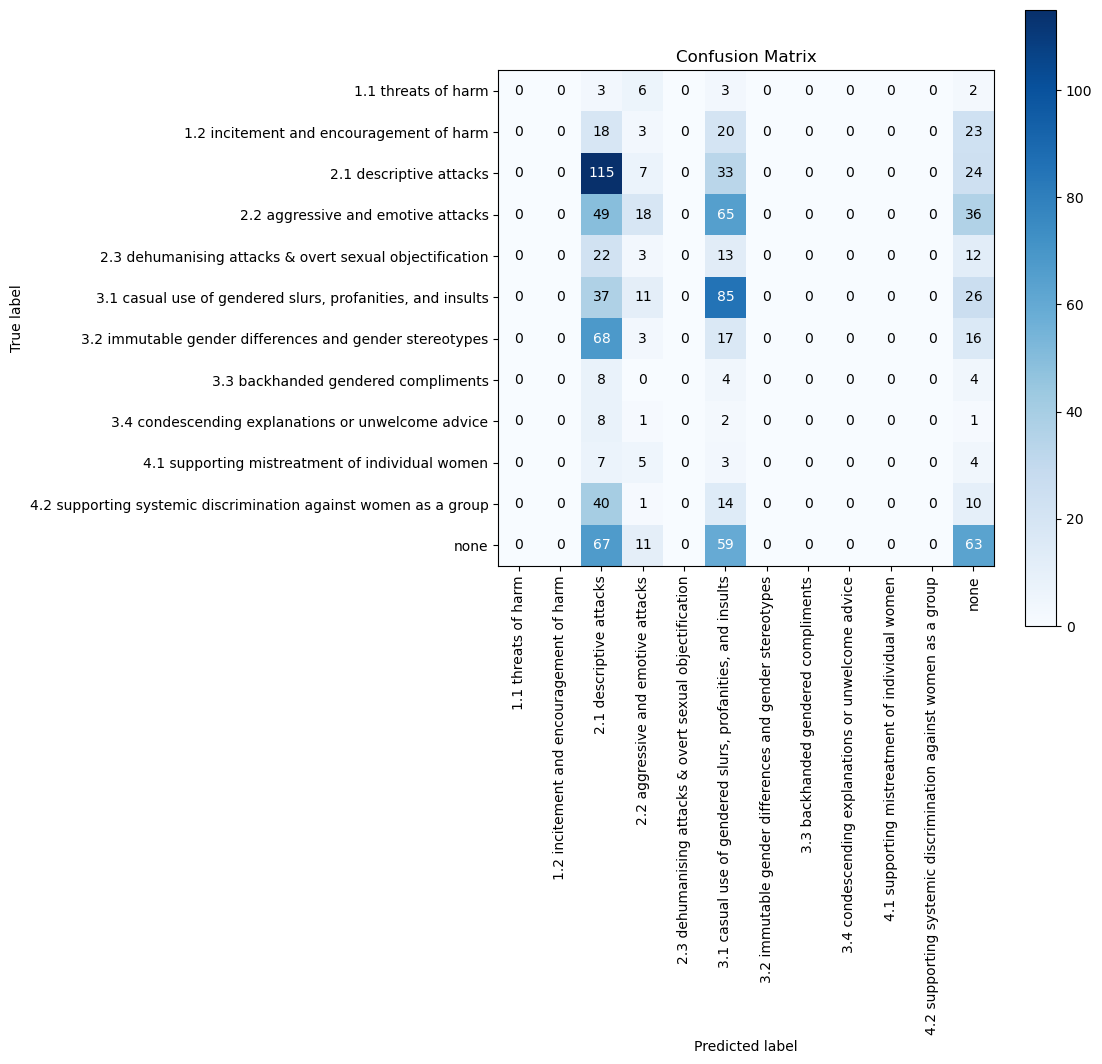

In [40]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(8,8),x_tick_rotation=90)
plt.savefig(os.path.join(os.path.curdir, "result", "task_c_confusion_matrix"))

In [41]:
print(classification_report(y_true, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv(os.path.join(os.path.curdir, "result", "task_c_classification_report"), index= True)

                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.00      0.00      0.00        14
                       1.2 incitement and encouragement of harm       0.00      0.00      0.00        64
                                        2.1 descriptive attacks       0.26      0.64      0.37       179
                             2.2 aggressive and emotive attacks       0.26      0.11      0.15       168
        2.3 dehumanising attacks & overt sexual objectification       0.00      0.00      0.00        50
     3.1 casual use of gendered slurs, profanities, and insults       0.27      0.53      0.36       159
        3.2 immutable gender differences and gender stereotypes       0.00      0.00      0.00       104
                            3.3 backhanded gendered compliments       0.00      0.00      0.00        16
             3.4 condescending explanations or unwelco

E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Softwares\Anaconda3\lib\site-packages\sklearn\metrics\_cla